# Detecting Human Activities Through Smartphone Sensor - Training

## Imports

In [1]:
# TF related imports
import tensorflow as tf
from tensorflow.keras.models import Model
import tensorflow.keras.layers as layer
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

#scikit related imports
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import confusion_matrix

# other generic imports
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from mlxtend import plotting
from tqdm import tqdm
from datetime import timedelta
import time


2024-11-20 08:23:47.180872: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-20 08:23:47.195446: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-20 08:23:47.199682: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-20 08:23:47.210844: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-20 08:23:47.992336: W tensorflow/comp

## Global Variables

In [2]:
# global variables
PBAR_FORMAT='{desc:12} {percentage:3.0f}%|{bar:27}| [ {n:4d}/{total:4d}, {elapsed}<{remaining}{postfix} ]'

ACTIVITY_CODES_MAPPING = {'A': 'walking',
                          'B': 'jogging',
                          'C': 'stairs',
                          'D': 'sitting',
                          'E': 'standing',
                          'F': 'typing',
                          'G': 'brushing teeth',
                          'H': 'eating soup',
                          'I': 'eating chips',
                          'J': 'eating pasta',
                          'K': 'drinking from cup',
                          'L': 'eating sandwich',
                          'M': 'kicking soccer ball',
                          'O': 'playing catch tennis ball',
                          'P': 'dribbling basket ball',
                          'Q': 'writing',
                          'R': 'clapping',
                          'S': 'folding clothes'}
# csv file column names
COL_NAMES =  ['id' , 'activity_code' , 'timestamp', 'x', 'y', 'z']
# training verbose
VERBOSE = 1
# rnadom state for split
RANDOM_STATE=12345



## Dataset, Model and Trainer

### Helper functions

In [3]:
def get_activity_code(activity_names):
    cat_len=len(activity_names)
    activity_code={}
    for idx, an in enumerate(activity_names):
        for k in ACTIVITY_CODES_MAPPING.keys() :
            if ACTIVITY_CODES_MAPPING[k]==an:
                key = k
        activity_code[key]=idx
    
    assert(len(activity_code.keys())== cat_len)
    
    print(f"{activity_code}")
    print(f"Number of Categories {cat_len}")
    return activity_code, cat_len

def sliding_window(dataset, window_size, step_size):  
    x_list, y_list, z_list = [], [], []
    targets_list = []
    for i in range(0, dataset.shape[0] - window_size, step_size):
        x_list.append(dataset["x"].values[i: i + window_size])
        y_list.append(dataset["y"].values[i: i + window_size])
        z_list.append(dataset["z"].values[i: i + window_size])
        targets_list.append(stats.mode(dataset["activity_code"][i: i + window_size])[0])

    feature_list = [x_list, y_list, z_list]

    feature_list = [np.array(data_list) for data_list in feature_list]
    dataset = np.stack(feature_list, axis = 2)

    return dataset, targets_list

### Dataset

In [4]:
def WISDM_Dataset(dir, window_size, step_size, activity_code):
    window_size = window_size
    step_size = step_size
    path = dir
    column_names = COL_NAMES
    activity_dic = activity_code
    filelist_train = sorted([txt for txt in os.listdir(path + "/") if txt[-4:] == ".txt"])
    columns = ["x", "y", "z"]
        
    # Training data
    dataset_train = pd.DataFrame()

    for txt in tqdm(filelist_train, desc="loading data", bar_format=PBAR_FORMAT):
        dataset_tmp = pd.read_csv(path + '/' + txt, header = None, names = column_names, comment = ";")
        for k in activity_dic.keys():
            df_tmp = dataset_tmp[dataset_tmp['activity_code']==k][0:2400]
            dataset_train = pd.concat([dataset_train, df_tmp])
    print(dataset_train)

    # normalize the data
    dataset_train["activity_code"] = dataset_train["activity_code"].map(activity_dic)
    labels = dataset_train["activity_code"].to_numpy()

    scaler = RobustScaler()
    dataset_train = scaler.fit_transform(dataset_train[["x", "y", "z"]])
    dataset_train = pd.DataFrame(data = dataset_train, columns = ["x", "y", "z"])
    dataset_train["activity_code"] = labels
    
    # feature engineering
    dataset_train, targets_list = sliding_window(dataset_train, window_size, step_size)
    targets = np.array(targets_list)
    return dataset_train, targets

### Model

In [5]:
def lstm_net(data, num_classes):
    x_input = layer.Input(shape = (data.shape[-2:]))

    x = layer.Bidirectional(layer.LSTM(256, return_sequences = True))(x_input)
    x = layer.BatchNormalization()(x)
    x = layer.Bidirectional(layer.LSTM(128, return_sequences = True))(x)
    x = layer.BatchNormalization()(x)

    x = layer.Flatten()(x)

    x = layer.Dense(128, activation = "relu")(x)
    x = layer.BatchNormalization()(x)
    x = layer.Dropout(0.5)(x)
    x_output = layer.Dense(num_classes, activation = "softmax")(x)

    model = Model(inputs = x_input, outputs = x_output, name = "LSTM_NET")

    return model


### Plotting function

In [6]:
def plot_loss_acc(epochs, train_losses, train_acc, test_losses, test_acc, fold):
    fig, ax1 = plt.subplots()
    xaxis = list(range(1, epochs + 1))
    plt_train_loss = ax1.plot(xaxis, train_losses, label = "Training Loss", color="red")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2 = ax1.twinx()
    plt_train_acc = ax2.plot(xaxis, train_acc, label = "Training Accuracy", color="green")
    ax2.set_ylabel("Accuracy in %")
    ax2.set_ylim(0.0, 100.0)

    plt_val_loss = ax1.plot(xaxis, test_losses, label = "Validation Loss", color="firebrick")
    plt_val_acc = ax2.plot(xaxis, test_acc, label = "Validation Accuracy", color="limegreen")

    lines = plt_train_loss + plt_train_acc + plt_val_loss + plt_val_acc
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels)
    fold = " Fold " + str(fold) 
    plt.title("Loss and Accuracy" + fold)
    plt.show()

def plot_confusion_matrix(y_pred, y_valid, fold):
    conf_matrix = confusion_matrix(y_valid, y_pred)
    plotting.plot_confusion_matrix(conf_mat = conf_matrix,
                                   class_names = ACTIVITY_NAMES,
                                   show_normed = True,
                                   figsize = (10, 7),
                                   colorbar = True)
    plt.title("Confusion matrix Fold " + str(fold))
    plt.show()



### Trainer function

In [7]:

def train(cat_len, batch_size, num_epochs, k_fold, train_ds, target_ds):
    val_acc_last = []
    
    training_data={}
    start_time = time.time()
    for fold, (train_index, test_index) in enumerate(k_fold.split(train_ds, target_ds)):
        print(f"Running fold: {fold}")
        x_train, x_valid = train_ds[train_index], train_ds[test_index]
        y_train, y_valid = target_ds[train_index], target_ds[test_index]
        
        # convert to tf dataset
        train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size).with_options(options)
        valid_data = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size).with_options(options)
        
        model = lstm_net(train_ds, cat_len)
        
        model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
        
        learning_rate = ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 5, verbose = VERBOSE)
        early_stopping = EarlyStopping(monitor = "val_loss", patience = 10, verbose = VERBOSE, mode = "min", 
                                       restore_best_weights = True)
        
        # model training
        model_data = model.fit(train_data, 
                                validation_data = valid_data, 
                                epochs = num_epochs,
                                verbose = VERBOSE,
                                batch_size = BATCH_SIZE, 
                                callbacks = [learning_rate, early_stopping])

        # Plot loss and accuracy curves
        plot_loss_acc(len(model_data.history["loss"]), model_data.history["loss"], 
                                  [acc * 100.0 for acc in model_data.history["accuracy"]], 
                                  model_data.history["val_loss"], 
                                  [acc * 100.0 for acc in model_data.history["val_accuracy"]], str(fold))
        
        val_acc_last.append(np.around(100.0 * model_data.history["val_accuracy"][-1], 2))
        # Plot confusion matrix
        y_pred = np.argmax(model.predict(valid_data, batch_size = BATCH_SIZE), axis = 1)
        print("\n")
        plot_confusion_matrix(y_pred, y_valid, fold) 
        training_data[fold] = {'model_data':model_data,
                               'y_pred': y_pred, 
                               'y_valid':y_valid}
        print(f'Time elapsed: {timedelta(microseconds=int((time.time()-start_time)*1000000))}')
    
    print(f'Total Training Time: {timedelta(seconds=int(time.time()-start_time))}')
    print("Val Acc per fold:", val_acc_last)
    return training_data


## Training on watch accelerometer

### Hyper parameters

In [8]:
##################################################################
#Hyperparameter
##################################################################
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
NUM_SPLITS=5
DATA_DIR="../dataset/raw/watch/accel"

### Initialize Dataset

In [9]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
# Dataset
train_ds, target_ds = WISDM_Dataset(dir = DATA_DIR,
                              window_size = WINDOW_SIZE,
                              step_size = STEP_SIZE,
                              activity_code = activity_code)
k_fold = KFold(n_splits = NUM_SPLITS,
           shuffle = True,
           random_state = RANDOM_STATE)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:14<00:00 ]


         id activity_code         timestamp         x         y         z
0      1600             A    90426708196641  7.091625 -0.591667  8.195502
1      1600             A    90426757696641  4.972757 -0.158317  6.696732
2      1600             A    90426807196641  3.253720 -0.191835  6.107758
3      1600             A    90426856696641  2.801216 -0.155922  5.997625
4      1600             A    90426906196641  3.770868 -1.051354  7.731027
...     ...           ...               ...       ...       ...       ...
65386  1650             S  2426124382870752  6.425738 -6.462100  1.874061
65387  1650             S  2426124432864802  6.267721 -6.217891  1.682525
65388  1650             S  2426124482858852  5.822399 -6.553080  1.079186
65389  1650             S  2426124532852902  5.590162 -7.029526  0.504578
65390  1650             S  2426124582846952  5.702689 -7.668778  0.317830

[1826400 rows x 6 columns]


### Model Summary

In [10]:
model = lstm_net(train_ds, cat_len)
print(model.summary())

2024-11-20 08:24:12.898321: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6634 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:65:00.0, compute capability: 7.5


Model: "LSTM_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 512)       │       532,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,748,111 (29.56 MB)

 Trainable params: 7,746,319 (29.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

None


### Training

Running fold: 0
Epoch 1/90


2024-11-20 08:24:17.468044: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 133ms/step - accuracy: 0.2278 - loss: 3.0941 - val_accuracy: 0.2031 - val_loss: 2.4420 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 128ms/step - accuracy: 0.3316 - loss: 2.2092 - val_accuracy: 0.1820 - val_loss: 2.3845 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.4135 - loss: 1.8507 - val_accuracy: 0.2598 - val_loss: 2.2188 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.4921 - loss: 1.5782 - val_accuracy: 0.2877 - val_loss: 2.1448 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.5655 - loss: 1.3392 - val_accuracy: 0.4175 - val_loss: 1.8420 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.6308 - loss: 1.1672 - val_accuracy: 0.4298 - val_loss: 1.7645 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.6602 - loss: 1.0603 - val_accura

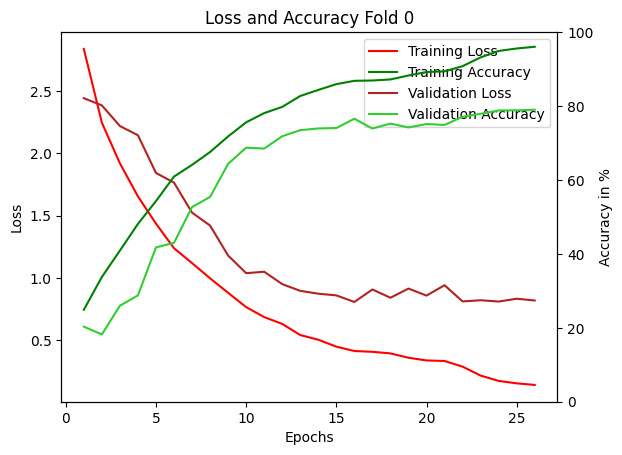

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step




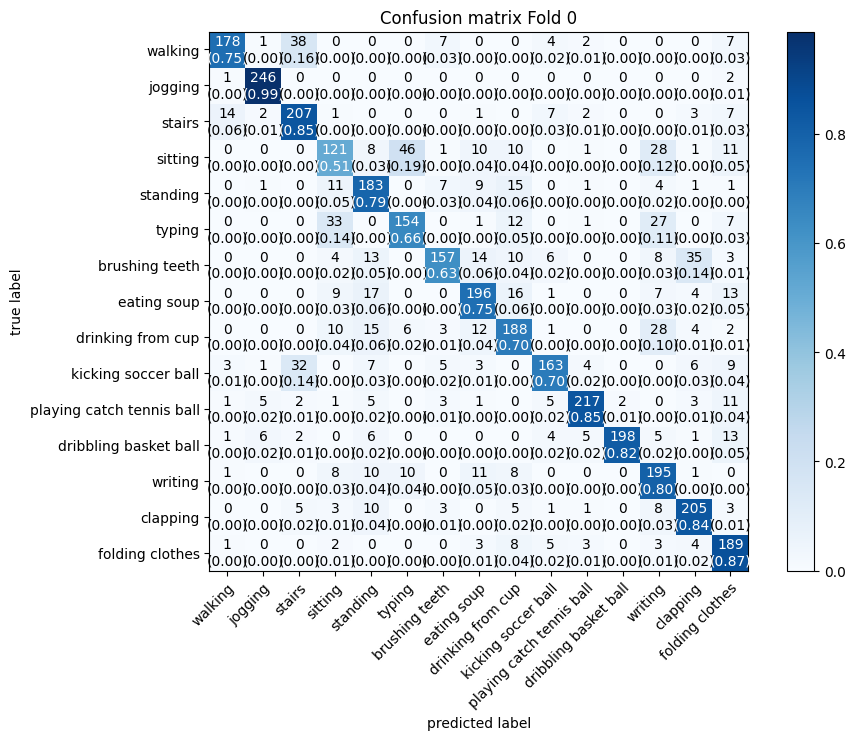

Time elapsed: 0:03:23.791691
Running fold: 1
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.2310 - loss: 2.9918 - val_accuracy: 0.1711 - val_loss: 2.3481 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.3644 - loss: 2.0802 - val_accuracy: 0.1544 - val_loss: 2.4417 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.4526 - loss: 1.7077 - val_accuracy: 0.2362 - val_loss: 2.2804 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5207 - loss: 1.4512 - val_accuracy: 0.3490 - val_loss: 2.0444 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5918 - loss: 1.2327 - val_accuracy: 0.4344 - val_loss: 1.7860 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6467 - loss: 1.0588 - val_accuracy: 0.5073 - val_loss: 1.5689 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 1

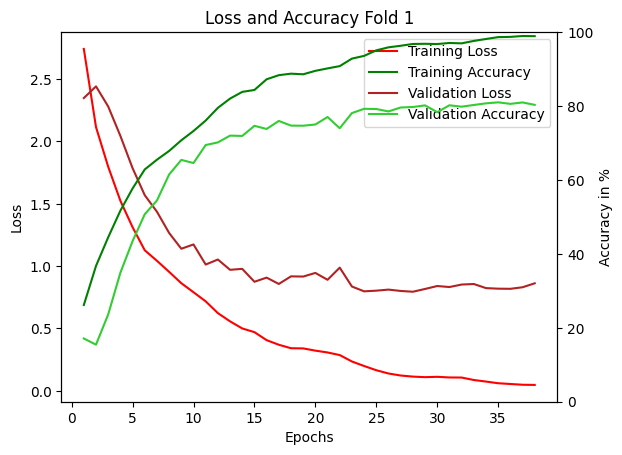

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




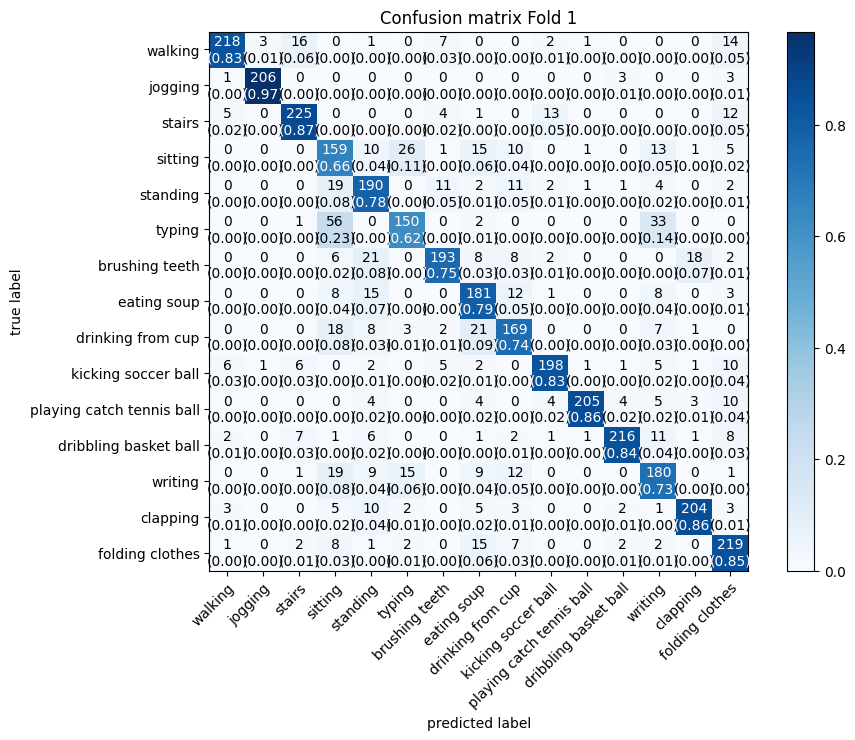

Time elapsed: 0:08:19.831303
Running fold: 2
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.2282 - loss: 3.0384 - val_accuracy: 0.2229 - val_loss: 2.3293 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.3255 - loss: 2.2183 - val_accuracy: 0.1396 - val_loss: 2.4557 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.4246 - loss: 1.8489 - val_accuracy: 0.1947 - val_loss: 2.3325 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.4996 - loss: 1.5982 - val_accuracy: 0.3376 - val_loss: 2.0743 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5524 - loss: 1.4163 - val_accuracy: 0.4001 - val_loss: 1.8814 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6152 - loss: 1.1996 - val_accuracy: 0.4918 - val_loss: 1.5834 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 1

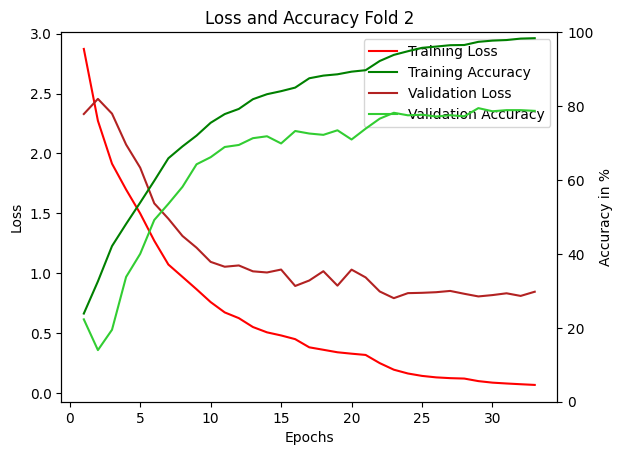

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step




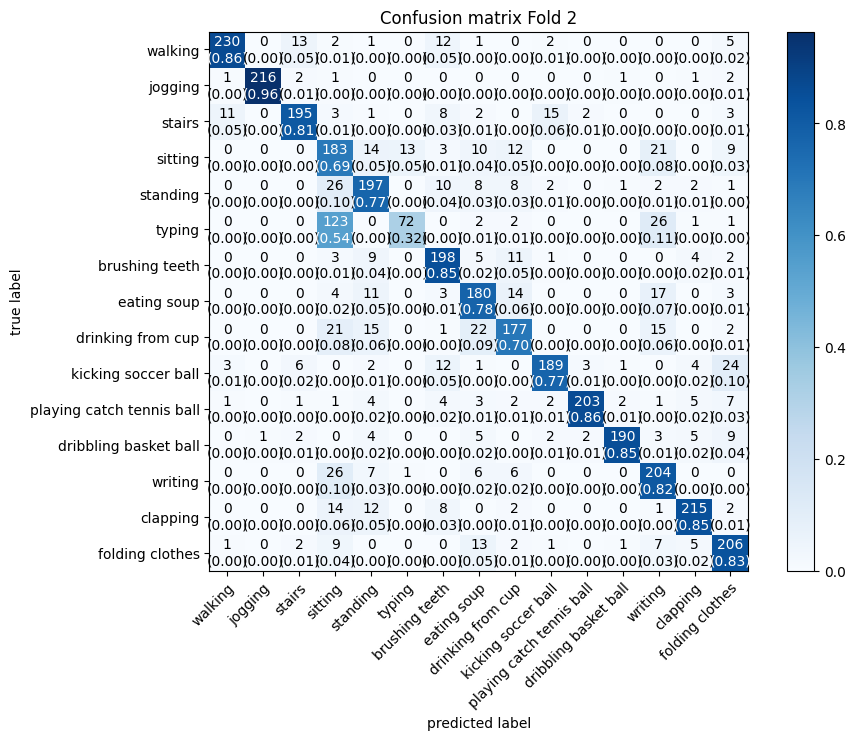

Time elapsed: 0:12:37.251829
Running fold: 3
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.2201 - loss: 3.1566 - val_accuracy: 0.2744 - val_loss: 2.2735 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.3272 - loss: 2.2536 - val_accuracy: 0.1887 - val_loss: 2.3922 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.4222 - loss: 1.8226 - val_accuracy: 0.2048 - val_loss: 2.2809 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5014 - loss: 1.5322 - val_accuracy: 0.3108 - val_loss: 1.9834 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5685 - loss: 1.3160 - val_accuracy: 0.4107 - val_loss: 1.8249 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6253 - loss: 1.1471 - val_accuracy: 0.4814 - val_loss: 1.5800 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 1

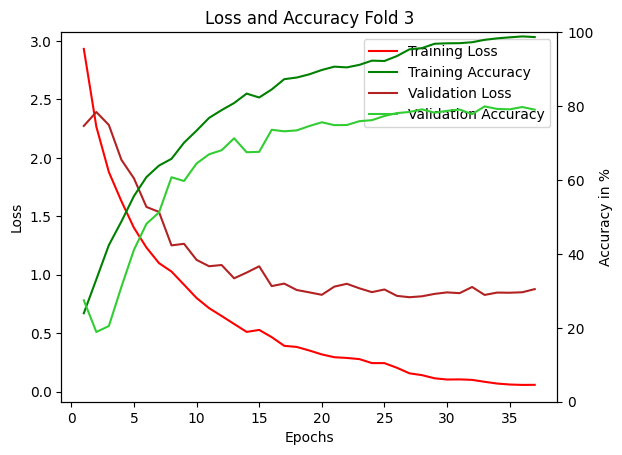

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




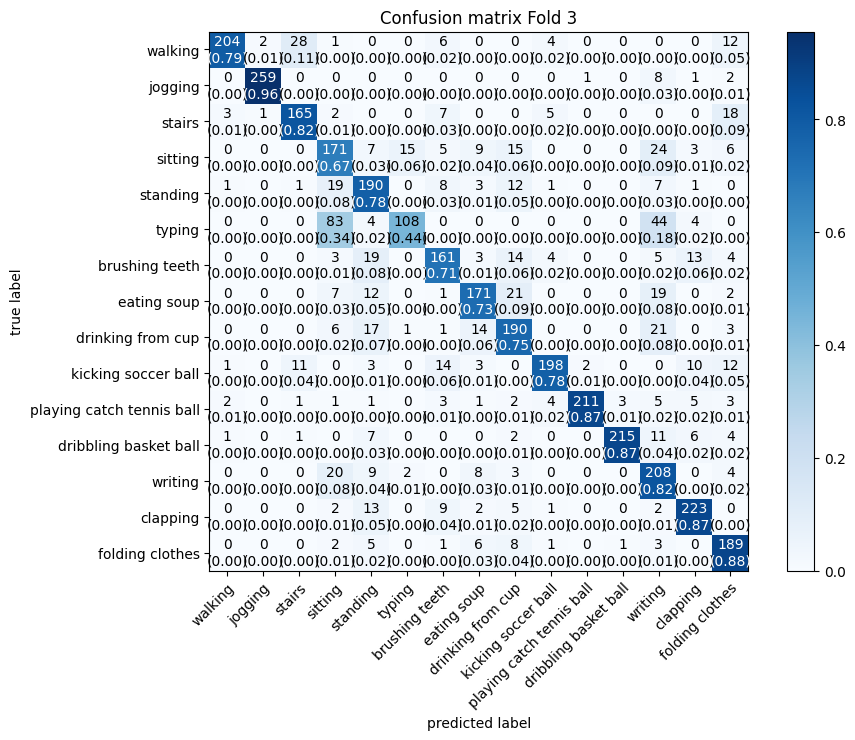

Time elapsed: 0:17:24.678632
Running fold: 4
Epoch 1/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.2065 - loss: 3.2138 - val_accuracy: 0.2889 - val_loss: 2.2734 - learning_rate: 0.0010
Epoch 2/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.3542 - loss: 2.1040 - val_accuracy: 0.2809 - val_loss: 2.2592 - learning_rate: 0.0010
Epoch 3/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.4455 - loss: 1.7236 - val_accuracy: 0.3420 - val_loss: 2.1149 - learning_rate: 0.0010
Epoch 4/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5314 - loss: 1.4510 - val_accuracy: 0.3913 - val_loss: 1.9535 - learning_rate: 0.0010
Epoch 5/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5886 - loss: 1.2444 - val_accuracy: 0.4556 - val_loss: 1.7283 - learning_rate: 0.0010
Epoch 6/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6451 - loss: 1.0824 - val_accuracy: 0.4844 - val_loss: 1.6034 - learning_rate: 0.0010
Epoch 7/90
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 1

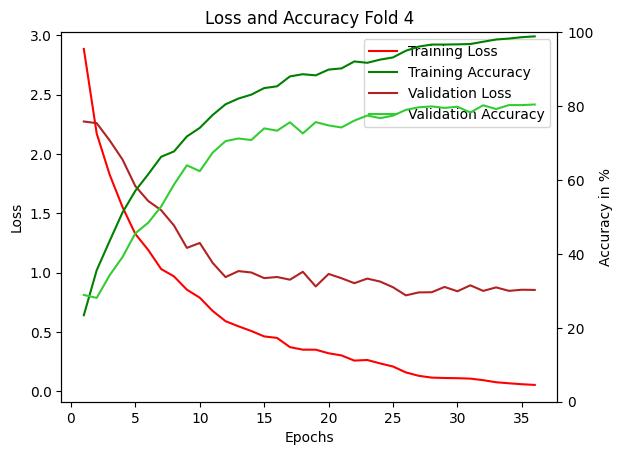

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




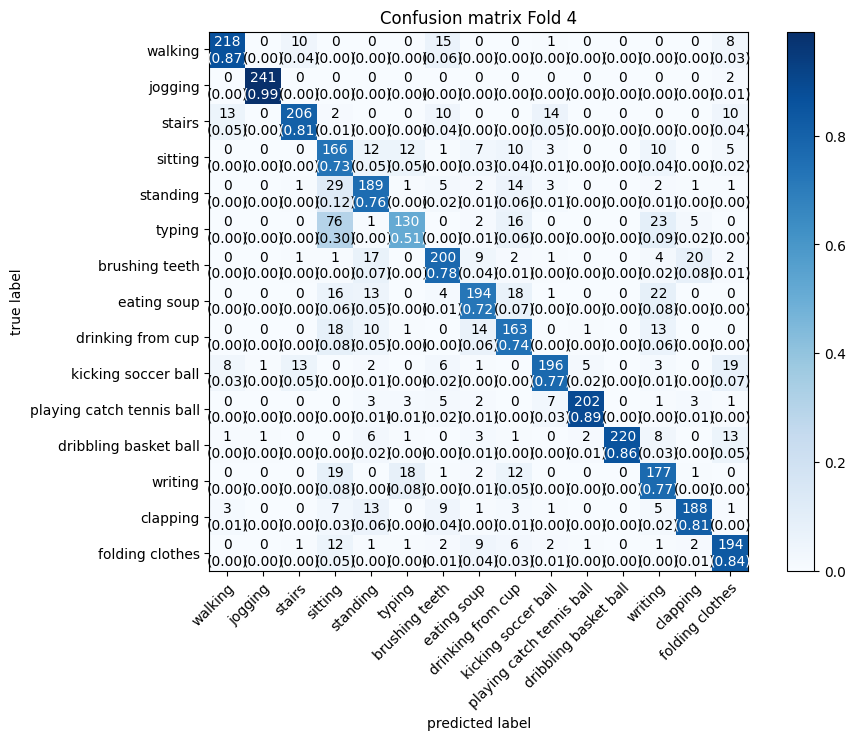

Time elapsed: 0:22:04.731171
Total Training Time: 0:22:04
Val Acc per fold: [79.0, 80.32, 78.7, 79.03, 80.42]


In [11]:
##################################################################
#Training
##################################################################
training_data = train(cat_len=cat_len,
                      batch_size=BATCH_SIZE,
                      num_epochs=NUM_EPOCHS,
                      k_fold=k_fold,
                      train_ds=train_ds,
                      target_ds=target_ds)

### Plot loss and accuracy

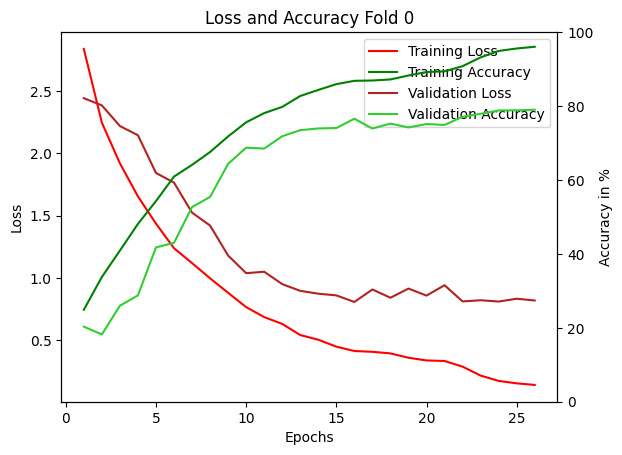

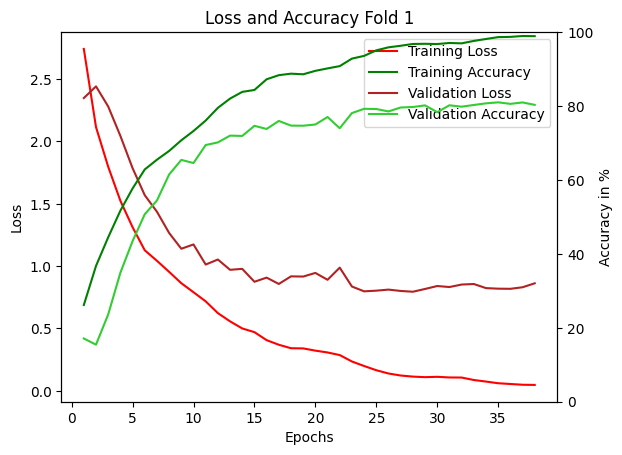

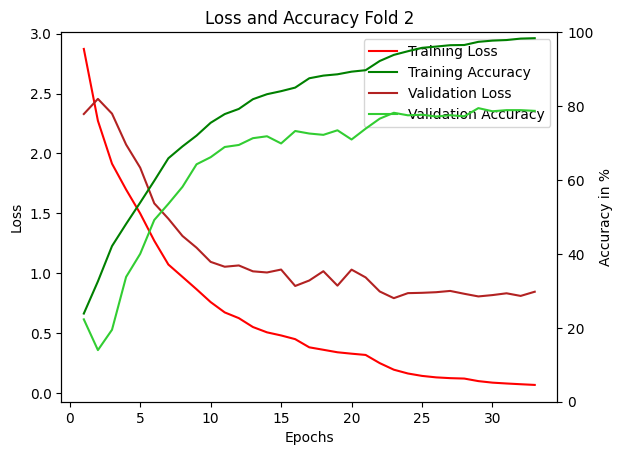

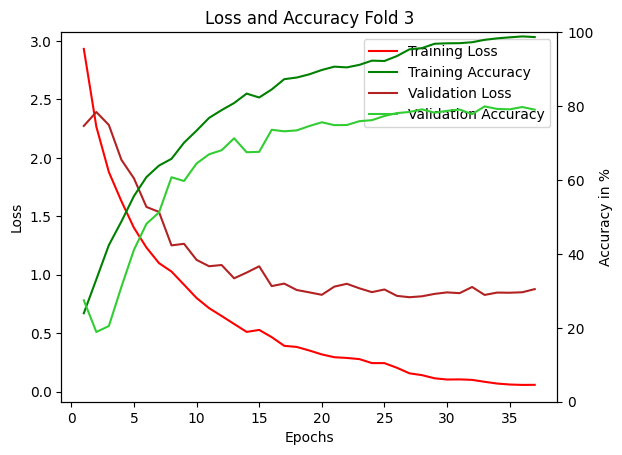

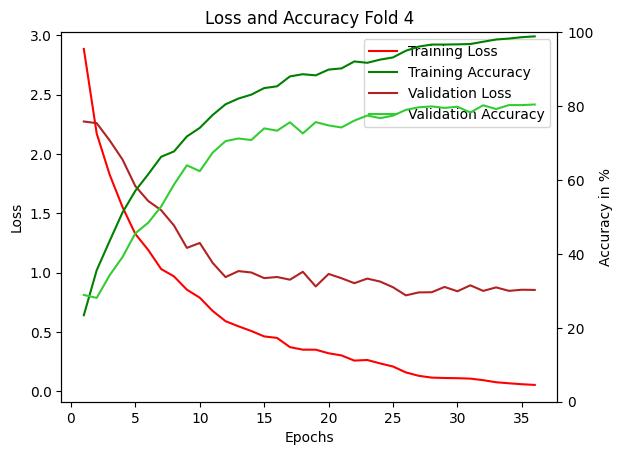

In [12]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    plot_loss_acc(len(model_data.history["loss"]), model_data.history["loss"], 
                              [acc * 100.0 for acc in model_data.history["accuracy"]], 
                              model_data.history["val_loss"], 
                              [acc * 100.0 for acc in model_data.history["val_accuracy"]], str(k))
        


### Plot Confusion matrix

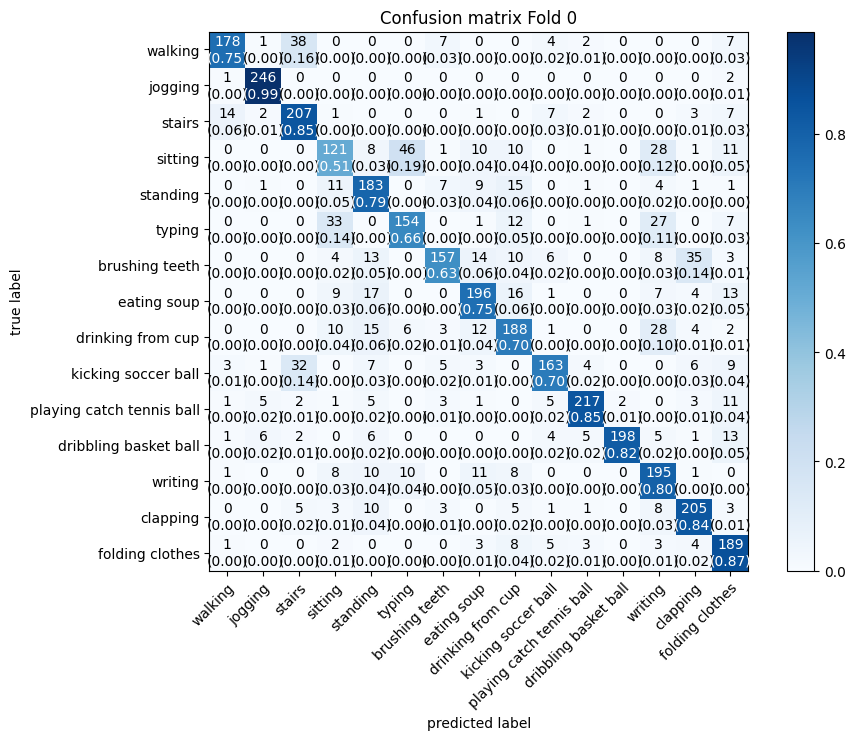

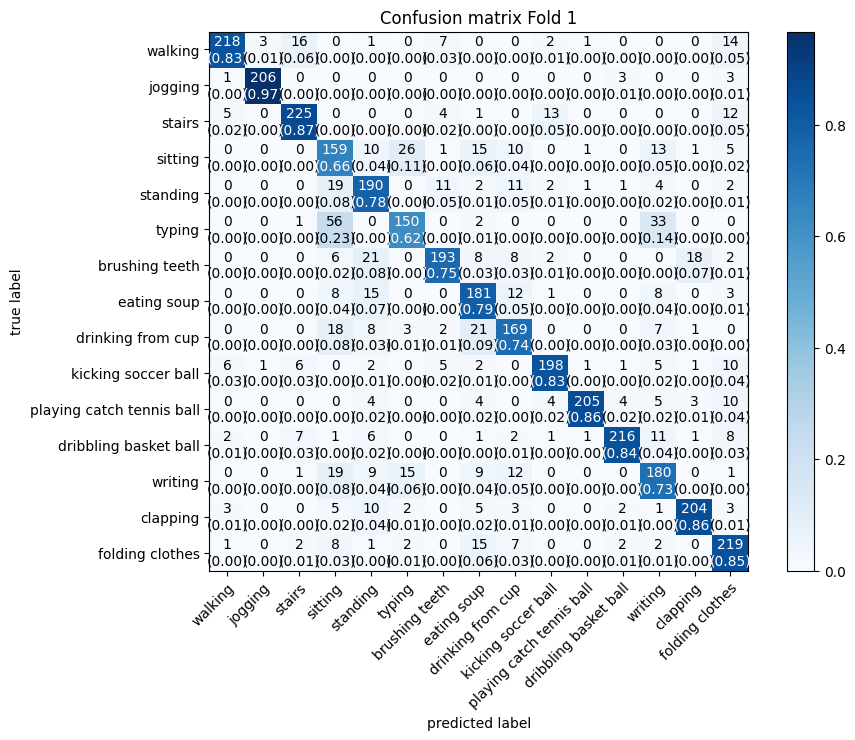

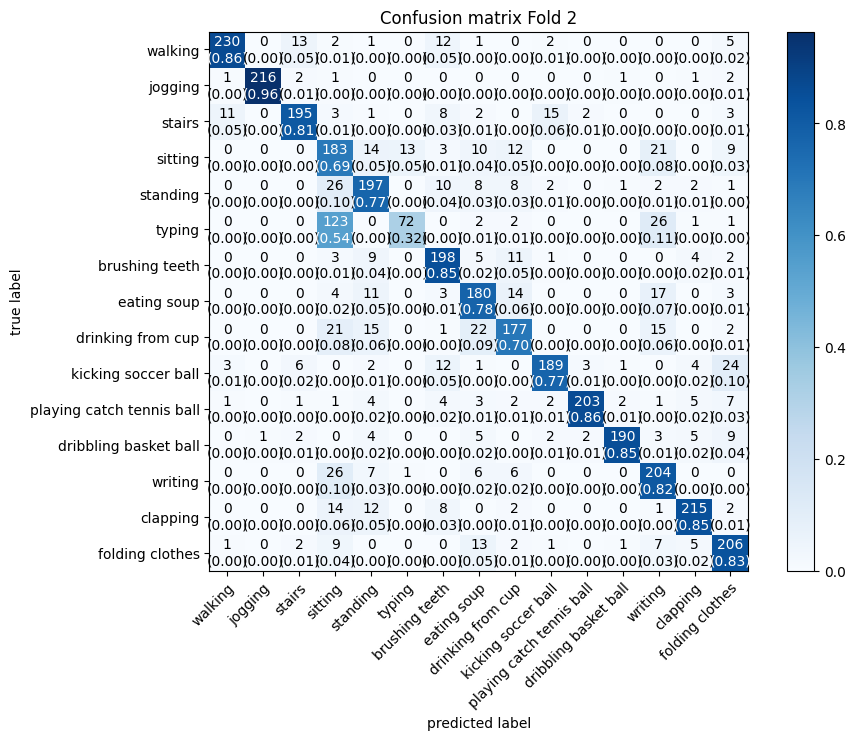

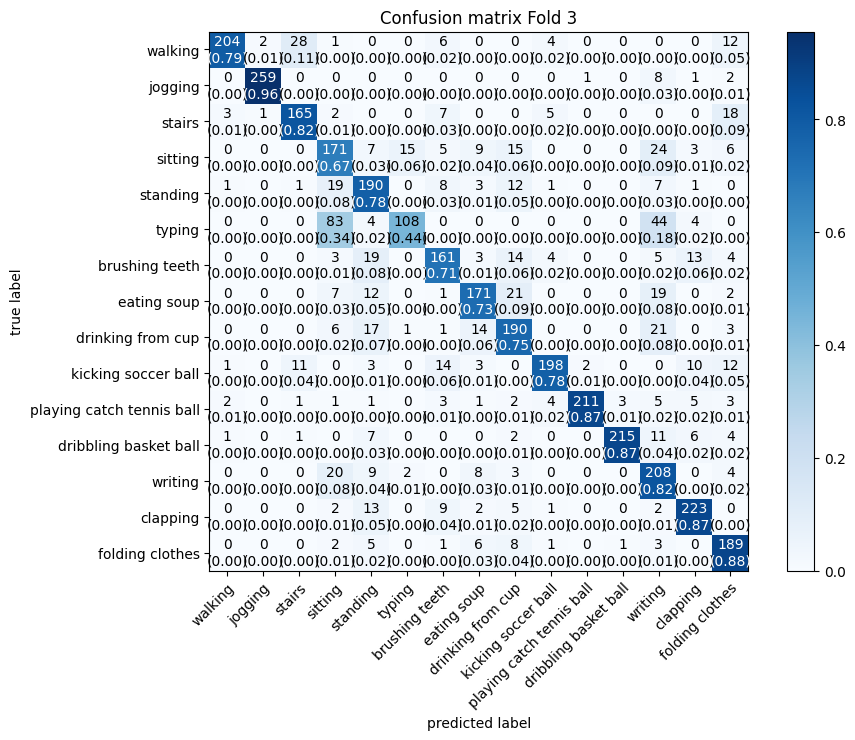

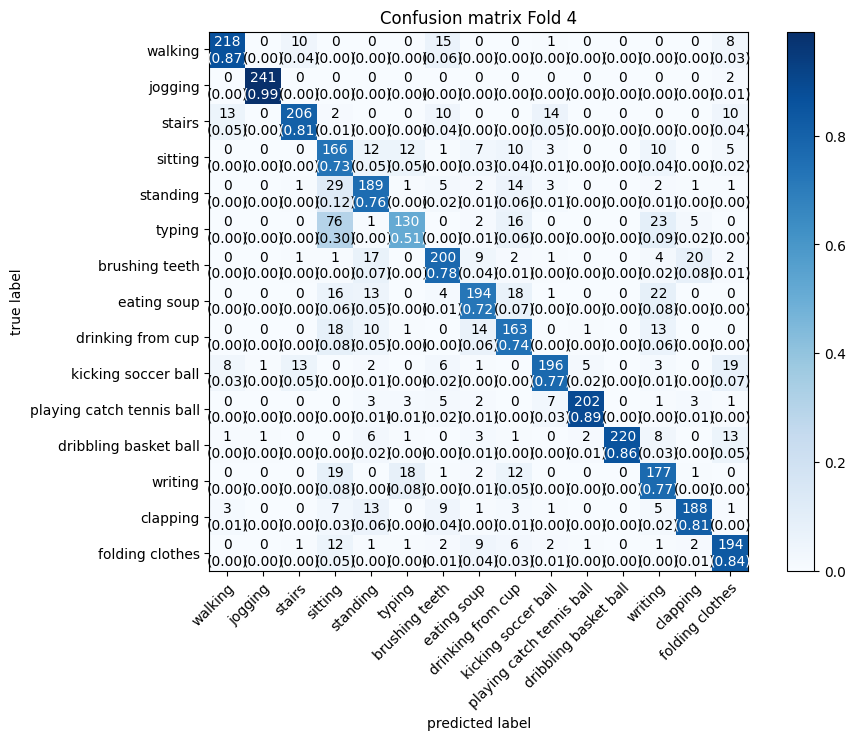

In [13]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    plot_confusion_matrix(y_pred, y_valid, k) 


### Accuracy Per Fold

In [14]:
print("Validation Accuracy fold wise")
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    val_acc = np.around(100.0 * model_data.history["val_accuracy"][-1], 2)
    print(f"fold {k}: {val_acc}")

Validation Accuracy fold wise
fold 0: 79.0
fold 1: 80.32
fold 2: 78.7
fold 3: 79.03
fold 4: 80.42


## Training on watch gyroscope sensor

### Hyper parameters

In [15]:
#ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "kicking soccer ball"]
ACTIVITY_NAMES = ["walking", "jogging", "stairs", "sitting", "standing", "typing", "brushing teeth",
                  "eating soup", "drinking from cup", 
                  "kicking soccer ball", "playing catch tennis ball", "dribbling basket ball", 
                  "writing", "clapping", "folding clothes"]
NUM_EPOCHS  = 90
BATCH_SIZE = 256
WINDOW_SIZE=200
STEP_SIZE=100
DATA_DIR="../dataset/raw/watch/gyro"

### Initialize Dataset

In [16]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
activity_code, cat_len = get_activity_code(ACTIVITY_NAMES)
# Dataset
train_ds, target_ds = WISDM_Dataset(dir = DATA_DIR,
                              window_size = WINDOW_SIZE,
                              step_size = STEP_SIZE,
                              activity_code = activity_code)
k_fold = KFold(n_splits = NUM_SPLITS,
           shuffle = True,
           random_state = RANDOM_STATE)

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'K': 8, 'M': 9, 'O': 10, 'P': 11, 'Q': 12, 'R': 13, 'S': 14}
Number of Categories 15


loading data 100%|███████████████████████████| [   51/  51, 00:12<00:00 ]


         id activity_code         timestamp         x         y         z
0      1600             A    90426757696641  0.314944 -1.022277 -0.309962
1      1600             A    90426807196641  0.387382 -0.618541 -0.048972
2      1600             A    90426856696641  0.070999 -0.209480 -0.195978
3      1600             A    90426906196641  0.037975  0.254976 -0.156563
4      1600             A    90426955696641  0.073129  0.719431 -0.001035
...     ...           ...               ...       ...       ...       ...
65352  1650             S  2426124432864802 -0.761755  1.007815 -0.567129
65353  1650             S  2426124482858852 -1.278409  1.254957 -0.672590
65354  1650             S  2426124532852902 -1.342324  1.273066 -0.770594
65355  1650             S  2426124582846952 -1.215558  1.024859 -0.732245
65356  1650             S  2426124632841002 -0.984396  0.541229 -0.325314

[1814400 rows x 6 columns]


### Model Summary

In [17]:
model = lstm_net(train_ds, cat_len)
print(model.summary())

Model: "LSTM_NET"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 200, 512)       │       532,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 200, 512)       │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 200, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 200, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,748,111 (29.56 MB)

 Trainable params: 7,746,319 (29.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

None


### Training

Running fold: 0
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 135ms/step - accuracy: 0.3337 - loss: 2.4002 - val_accuracy: 0.3828 - val_loss: 1.9361 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 130ms/step - accuracy: 0.5511 - loss: 1.3180 - val_accuracy: 0.4271 - val_loss: 1.7794 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.6192 - loss: 1.0815 - val_accuracy: 0.5068 - val_loss: 1.4806 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6970 - loss: 0.8551 - val_accuracy: 0.6004 - val_loss: 1.2470 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.7331 - loss: 0.7515 - val_accuracy: 0.6437 - val_loss: 1.0743 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.7669 - loss: 0.6328 - val_accuracy: 0.6580 - val_loss: 0.9725 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.8144 

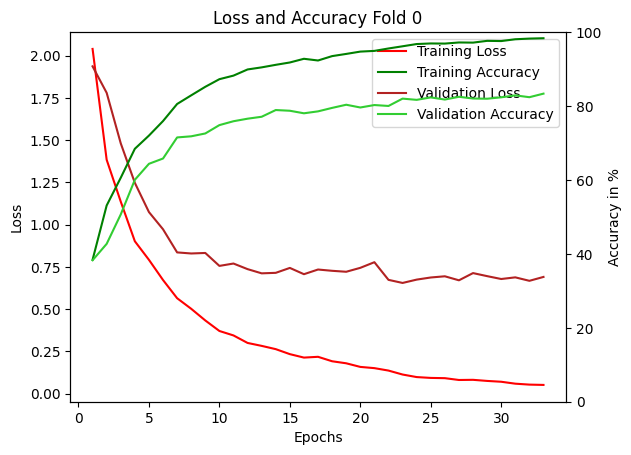

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




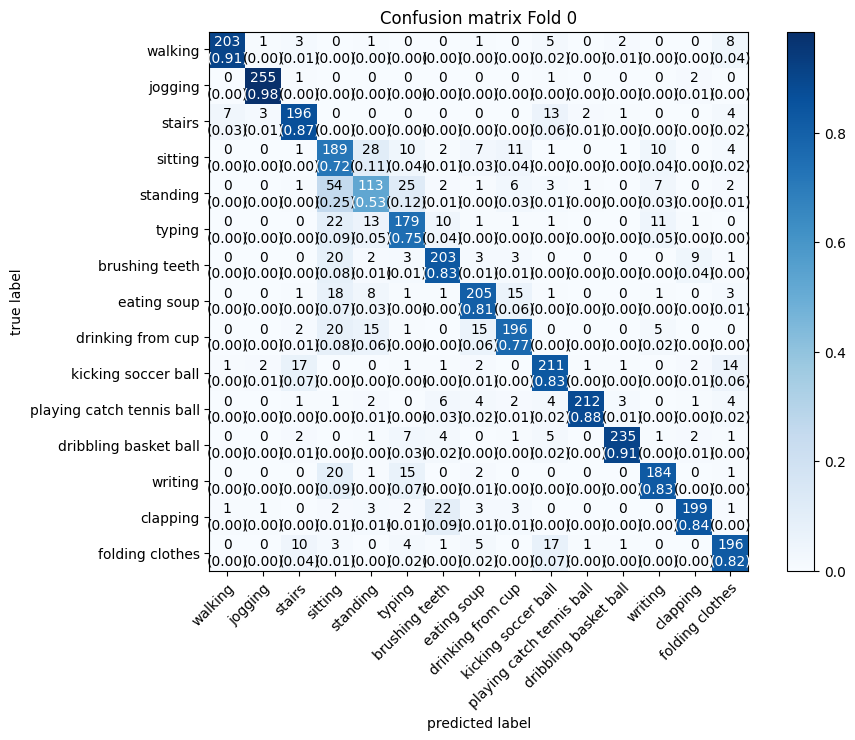

Time elapsed: 0:04:14.542964
Running fold: 1
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.3353 - loss: 2.3630 - val_accuracy: 0.3805 - val_loss: 2.0038 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5556 - loss: 1.3274 - val_accuracy: 0.4277 - val_loss: 1.9382 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6228 - loss: 1.0814 - val_accuracy: 0.5147 - val_loss: 1.6865 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6821 - loss: 0.8937 - val_accuracy: 0.6101 - val_loss: 1.3501 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7442 - loss: 0.7369 - val_accuracy: 0.6522 - val_loss: 1.0971 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7979 - loss: 0.5896 - val_accuracy: 0.6699 - val_loss: 0.9420 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 1

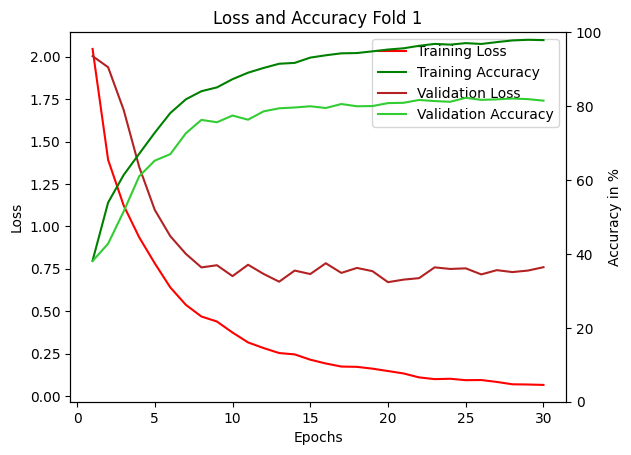

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




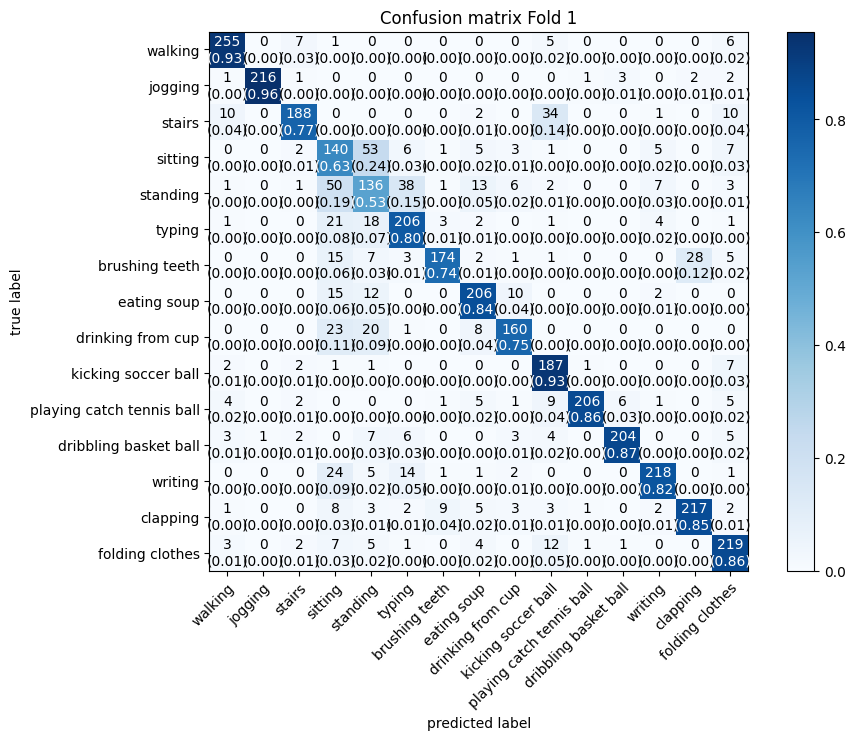

Time elapsed: 0:08:07.261339
Running fold: 2
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3458 - loss: 2.2848 - val_accuracy: 0.3396 - val_loss: 1.9968 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5465 - loss: 1.2895 - val_accuracy: 0.3724 - val_loss: 1.8985 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6132 - loss: 1.0562 - val_accuracy: 0.5289 - val_loss: 1.4974 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6826 - loss: 0.8803 - val_accuracy: 0.5772 - val_loss: 1.2273 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7354 - loss: 0.7373 - val_accuracy: 0.5849 - val_loss: 1.1658 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.7616 - loss: 0.6755 - val_accuracy: 0.6800 - val_loss: 0.9400 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 1

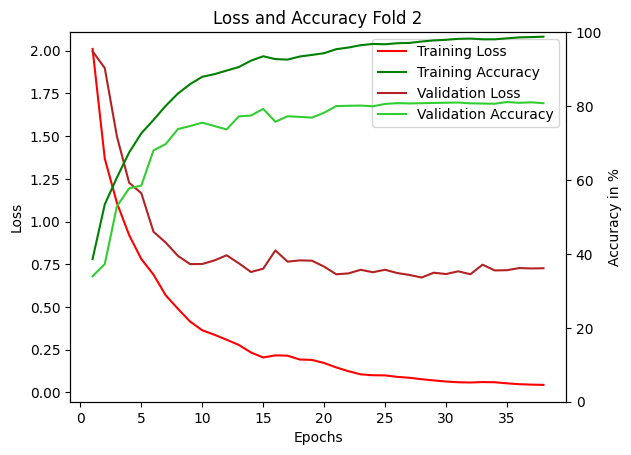

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




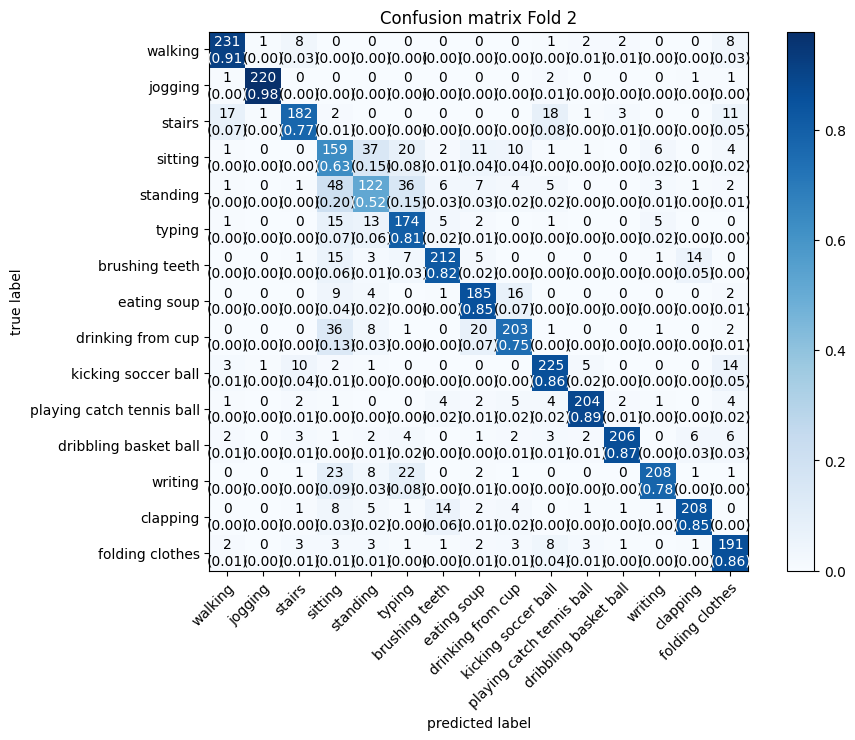

Time elapsed: 0:13:00.496331
Running fold: 3
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.3469 - loss: 2.3609 - val_accuracy: 0.3953 - val_loss: 1.8910 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.5376 - loss: 1.3113 - val_accuracy: 0.3658 - val_loss: 1.8457 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.6256 - loss: 1.0418 - val_accuracy: 0.4730 - val_loss: 1.5762 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7054 - loss: 0.8334 - val_accuracy: 0.5708 - val_loss: 1.3002 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 134ms/step - accuracy: 0.7421 - loss: 0.7326 - val_accuracy: 0.6505 - val_loss: 1.0600 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7950 - loss: 0.5852 - val_accuracy: 0.6706 - val_loss: 0.9451 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 1

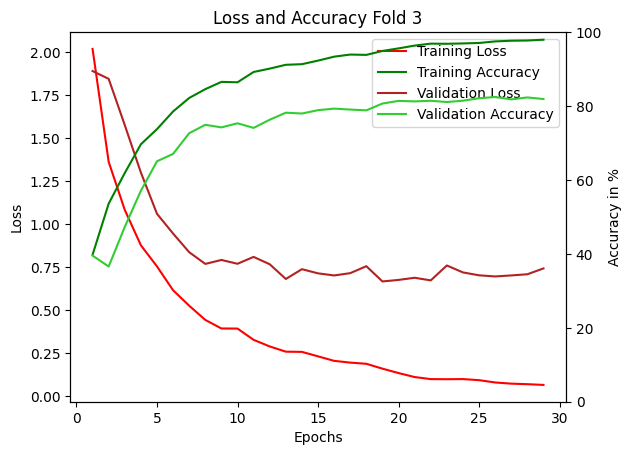

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step




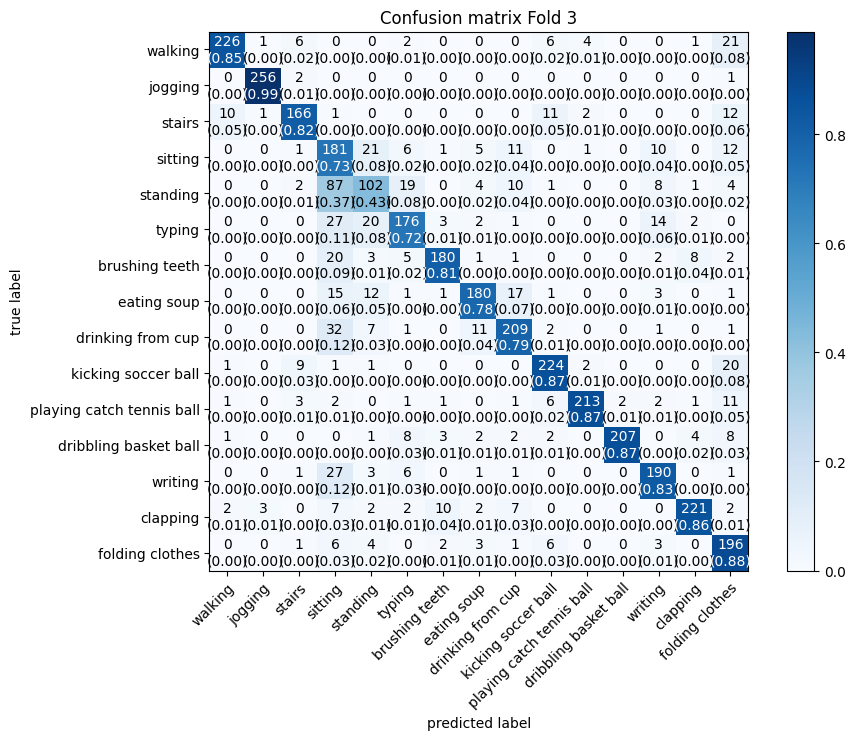

Time elapsed: 0:16:45.318577
Running fold: 4
Epoch 1/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 11s 136ms/step - accuracy: 0.3352 - loss: 2.2979 - val_accuracy: 0.3705 - val_loss: 1.9331 - learning_rate: 0.0010
Epoch 2/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.5378 - loss: 1.3110 - val_accuracy: 0.3906 - val_loss: 1.8819 - learning_rate: 0.0010
Epoch 3/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6281 - loss: 1.0376 - val_accuracy: 0.4994 - val_loss: 1.5691 - learning_rate: 0.0010
Epoch 4/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.6996 - loss: 0.8358 - val_accuracy: 0.5907 - val_loss: 1.2518 - learning_rate: 0.0010
Epoch 5/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7552 - loss: 0.6952 - val_accuracy: 0.6714 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 6/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 133ms/step - accuracy: 0.7860 - loss: 0.5932 - val_accuracy: 0.6869 - val_loss: 0.9283 - learning_rate: 0.0010
Epoch 7/90
57/57 ━━━━━━━━━━━━━━━━━━━━ 8s 1

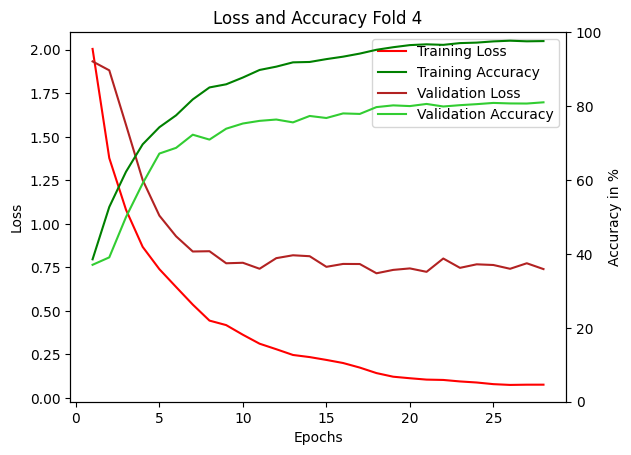

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step




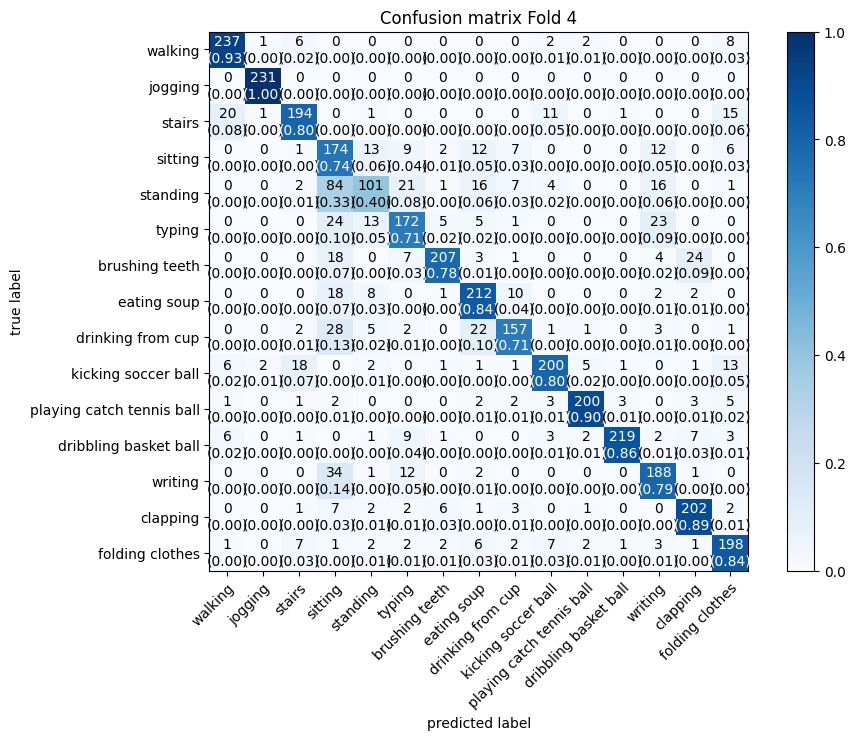

Time elapsed: 0:20:22.730828
Total Training Time: 0:20:22
Val Acc per fold: [83.36, 81.45, 80.76, 81.89, 81.01]


In [18]:
##################################################################
#Training
##################################################################
training_data = train(cat_len=cat_len,
                      batch_size=BATCH_SIZE,
                      num_epochs=NUM_EPOCHS,
                      k_fold=k_fold,
                      train_ds=train_ds,
                      target_ds=target_ds)

### Plot loss and accuracy

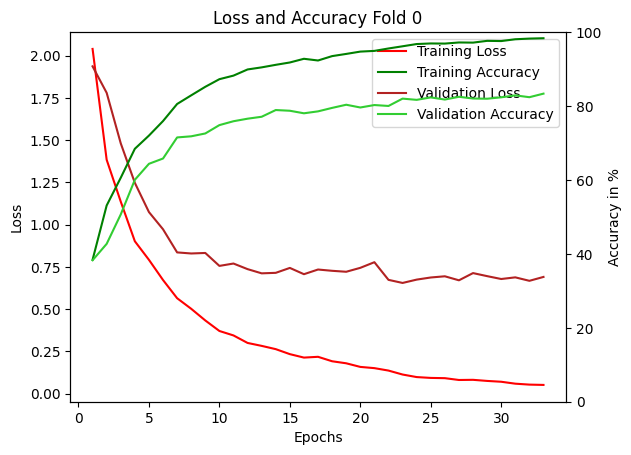

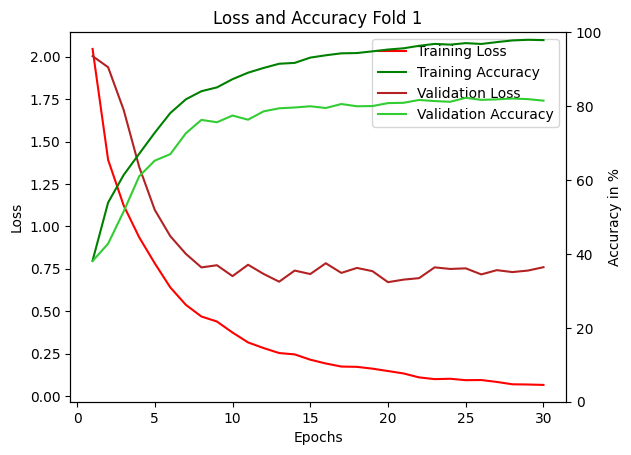

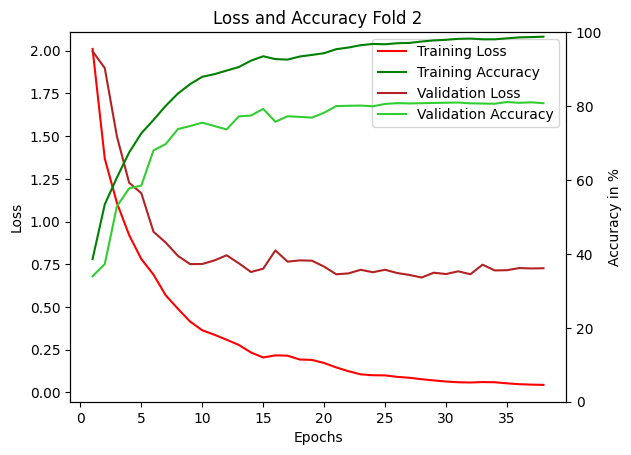

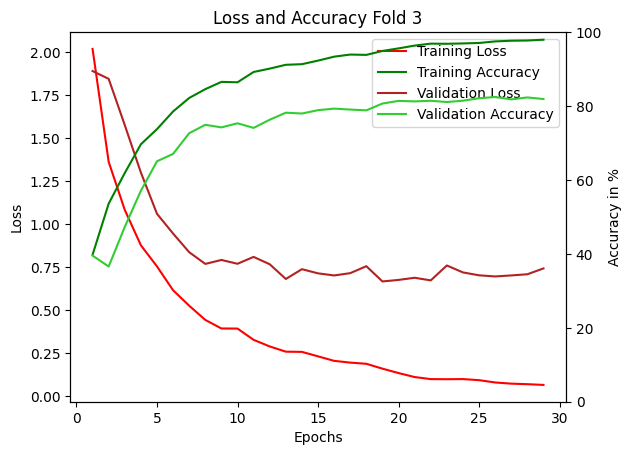

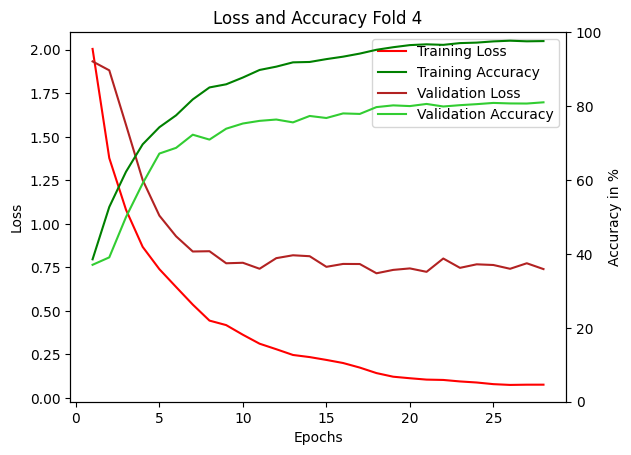

In [19]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    plot_loss_acc(len(model_data.history["loss"]), model_data.history["loss"], 
                              [acc * 100.0 for acc in model_data.history["accuracy"]], 
                              model_data.history["val_loss"], 
                              [acc * 100.0 for acc in model_data.history["val_accuracy"]], str(k))
        


### Plot Confusion matrix

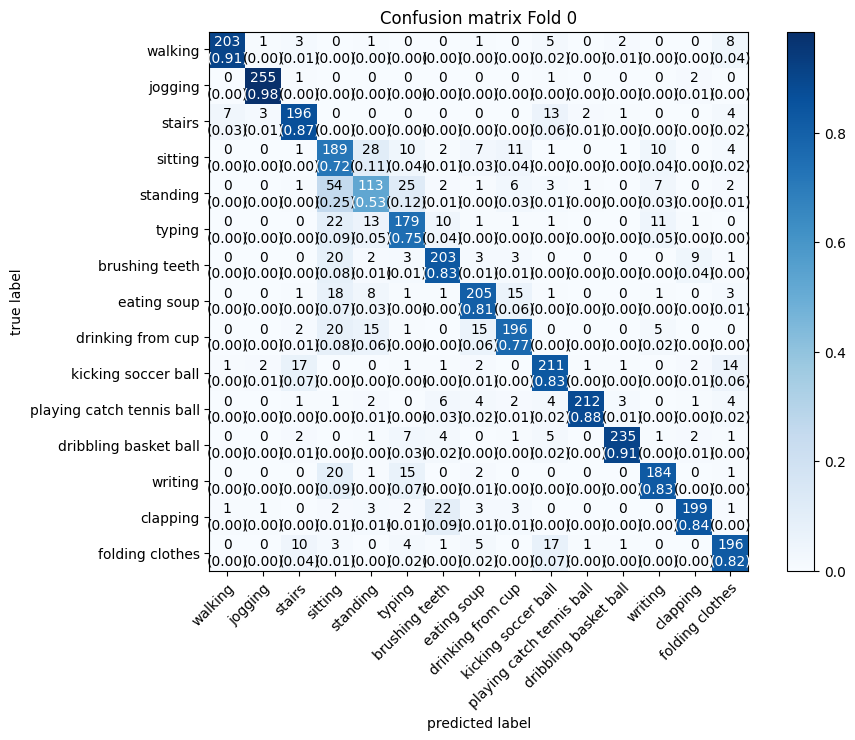

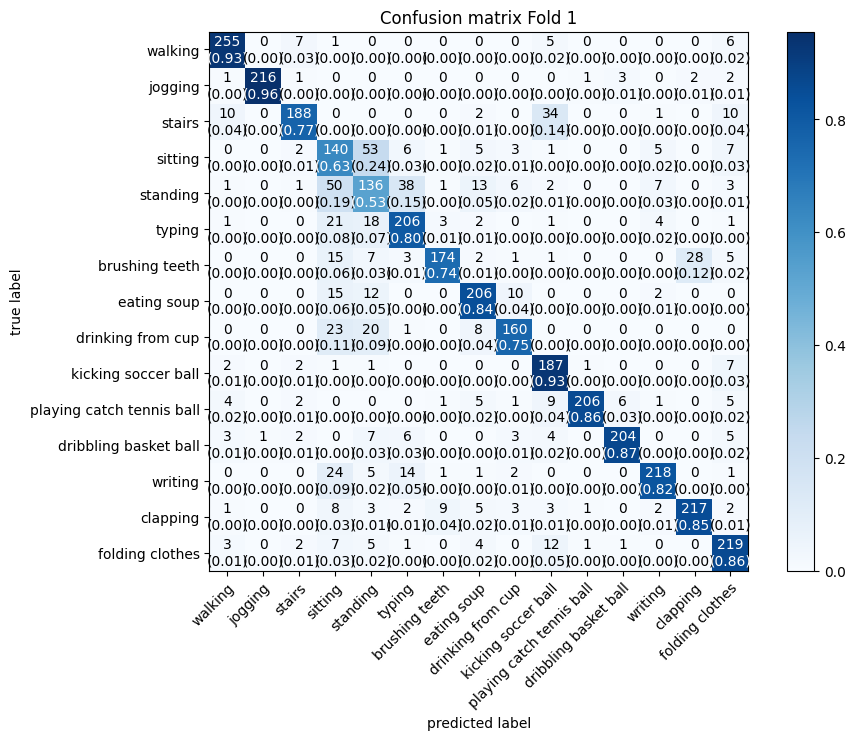

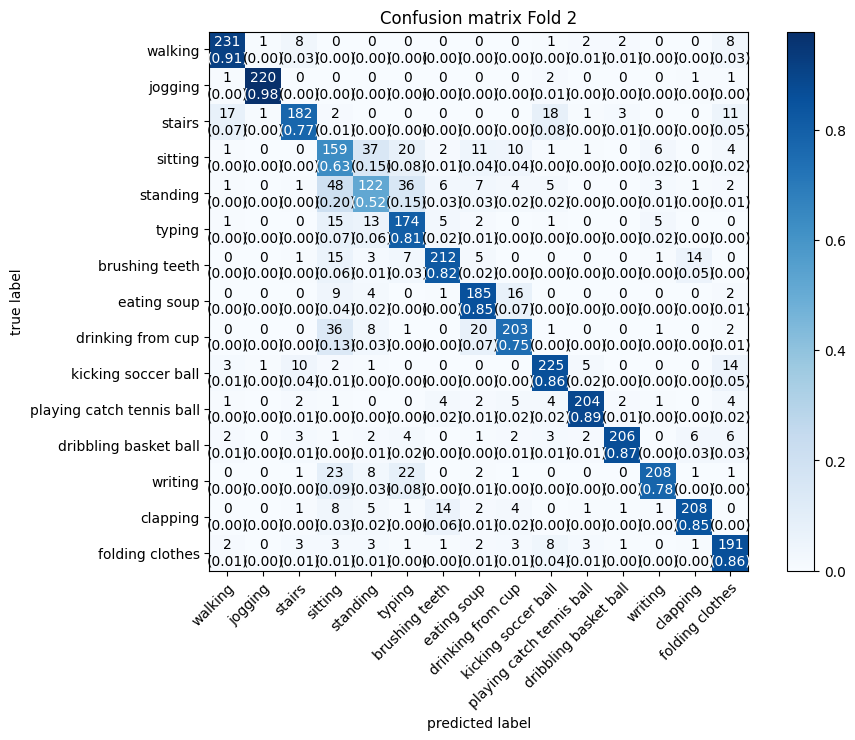

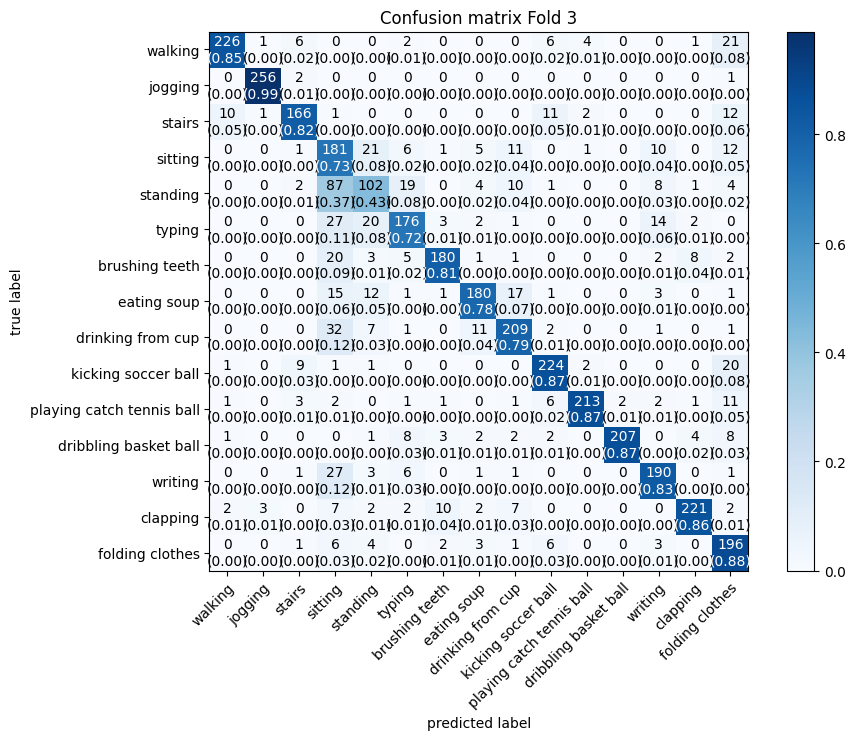

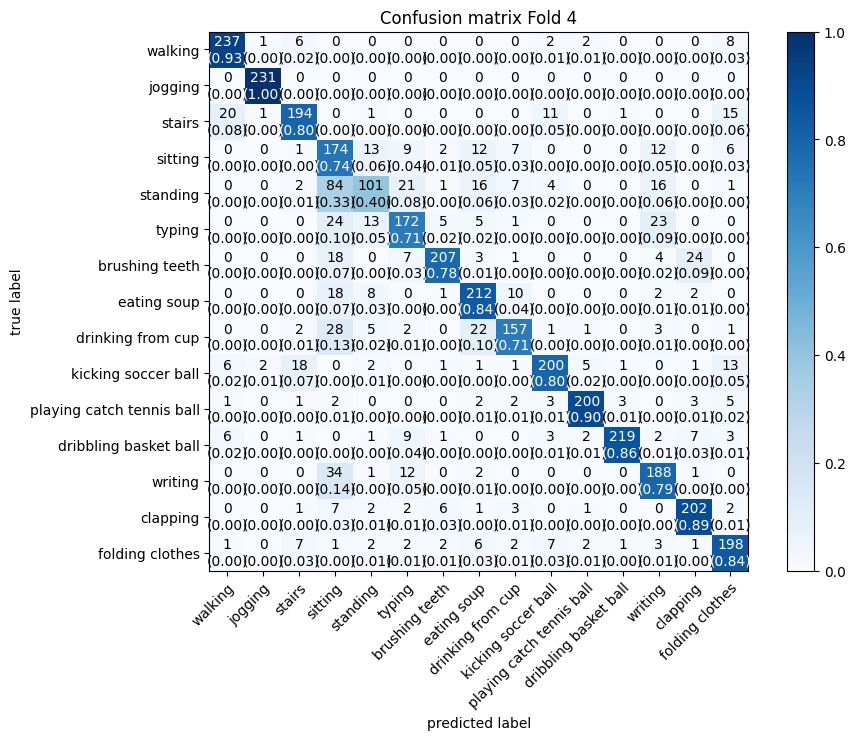

In [20]:
for k in training_data.keys():
    # Plot loss and accuracy curves
    y_pred = training_data[k]['y_pred']
    y_valid = training_data[k]['y_valid']
    plot_confusion_matrix(y_pred, y_valid, k) 


### Accuracy Per Fold

In [21]:
print("Validation Accuracy fold wise")
for k in training_data.keys():
    # Plot loss and accuracy curves
    model_data = training_data[k]['model_data']
    val_acc = np.around(100.0 * model_data.history["val_accuracy"][-1], 2)
    print(f"fold {k}: {val_acc}")

Validation Accuracy fold wise
fold 0: 83.36
fold 1: 81.45
fold 2: 80.76
fold 3: 81.89
fold 4: 81.01
